In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import os
import glob
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support

### Comparison Results Outputs

In [2]:
with open('/home/salipe/Desktop/GREAC/study-cases/sars_ids.txt', 'r') as f:
    ids_fasta = [line.strip() for line in f.readlines()]

id_to_variant = {}
for seq_id in ids_fasta:
    id_to_variant[seq_id.split('|')[0]] = seq_id.split('|')[1]+"|"+seq_id.split('|')[2]

print(f"Criados {len(id_to_variant)} mapeamentos")
print("Primeiros 5 mapeamentos:")
for i, (key, value) in enumerate(id_to_variant.items()):
    if i < 5:
        print(f"{key}: {value}")

Criados 334956 mapeamentos
Primeiros 5 mapeamentos:
MZ083615.1: SARS-CoV-2|Alpha_reducted
OD911548.1: SARS-CoV-2|Alpha_reducted
MZ195292.1: SARS-CoV-2|Alpha_reducted
MZ152291.1: SARS-CoV-2|Alpha_reducted
MZ358479.1: SARS-CoV-2|Alpha_reducted


In [2]:
h = '/home/salipe/Desktop/GREAC/study-cases'


In [4]:
def create_confusion_matrix_from_csv(original_data_path, title, id_to_variant):
    covlabels = ["Alpha", "Beta", "Delta", "Epsilon", "Eta", "Gamma", "Iota", "Kappa", "Lambda", "Omicron"]
    # denvlab = ["type1", "type2", "type3", "type4"]
    confusion_matrices = []
    labels = None
    
    for filepath in glob.glob(os.path.join(original_data_path, '*.csv')):
        df = None
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                lines = f.readlines()
           
            data = []
            for i, line in enumerate(lines):
                line = line.strip()
                if i == 0:  # Header
                    continue
                if line:
                    # Encontra a última vírgula (separador real)
                    last_comma = line.rfind(',')
                    if last_comma != -1:
                        id_part = line[:last_comma]
                        pred_part = line[last_comma + 1:]
                        data.append({'id': id_part, 'y_pred': pred_part})
            
            df = pd.DataFrame(data)
        except Exception as e:
            print(f"Erro ao processar {filepath}: {e}")

        
        # df = pd.read_csv(filepath, quotechar='"', escapechar='\\')
        
        # # Extrai y_true a partir da coluna 'id' to hbv outputs
        # df['y_true'] = df['id'].str.split('|').str[3]

        # to sars
        # df['y_true'] = df['id'].str.split('|').str[2]

        # to hiv
        # df['y_true'] = df['id'].str.split('|').str[1]

        # to denv outputs
        # df['y_true'] = df['id'].str.split('_').str[0]+"_reducted"

        # to denv,sars and hbv castor outputs
        df['y_true'] = df['id'].map(id_to_variant)

        y_true = df['y_true']
        y_pred = df['y_pred']
        
        # Define labels na primeira iteração
        if labels is None:
            labels = sorted(pd.unique(pd.Series(y_true)))
        
        # Calcula matriz de confusão para este arquivo
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        confusion_matrices.append(cm)
    
    if not confusion_matrices:
        raise ValueError("Nenhuma matriz de confusão foi calculada. Verifique os caminhos dos arquivos.")
    
    # Converte para array numpy para facilitar cálculos
    confusion_matrices = np.array(confusion_matrices)
    
    # Calcula média e desvio padrão das matrizes
    cm_mean = np.mean(confusion_matrices, axis=0)
    cm_std = np.std(confusion_matrices, axis=0)
       
    # Cria matriz combinada (média ± desvio padrão)
    cm_combined = pd.DataFrame(index=labels, columns=labels)
    for i, true_label in enumerate(labels):
        for j, pred_label in enumerate(labels):
            mean_val = cm_mean[i, j]
            std_val = cm_std[i, j]
            cm_combined.loc[true_label, pred_label] = f"{mean_val:.1f} ± {std_val:.1f}"
    
    # ===== NORMALIZAÇÃO E VISUALIZAÇÃO =====
    
    # Normaliza a matriz de confusão por linha (divide cada linha pela soma da linha)
    # Isso converte contagens absolutas em proporções/porcentagens por classe verdadeira
    cm_normalized = cm_mean / cm_mean.sum(axis=1, keepdims=True)
    cm_normalized_df = pd.DataFrame(cm_normalized, index=labels, columns=labels)
    
    # Calcula desvio padrão normalizado também
    cm_matrices_normalized = np.array([cm / cm.sum(axis=1, keepdims=True) for cm in confusion_matrices])
    cm_std_normalized = np.std(cm_matrices_normalized, axis=0)
    
    # Cria as anotações
    annotations = np.empty_like(cm_normalized, dtype=object)
    for i in range(cm_normalized.shape[0]):
        for j in range(cm_normalized.shape[1]):
            mean_val = cm_normalized[i, j]
            std_val = cm_std_normalized[i, j]
            annotations[i, j] = f"{mean_val*100:.1f}%\n±{std_val*100:.1f}%"
    
    # Criar figura
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Heatmap com matriz normalizada (valores entre 0 e 1)
    sns.heatmap(ax=ax,
                data=cm_normalized_df,
                annot=annotations,
                fmt="",
                cmap='YlOrRd',
                linecolor="black",
                linewidths=.1,
                cbar=False,
                vmin=0,
                vmax=1)
    
    ax.set_title(title)
    ax.set_xticklabels(covlabels, rotation=0)
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    ax.yaxis.set_ticklabels(covlabels)
    
    plt.savefig("castor_sars_cm_reduced.pdf", dpi=300, format="pdf", bbox_inches="tight")
    plt.tight_layout()
    plt.show()

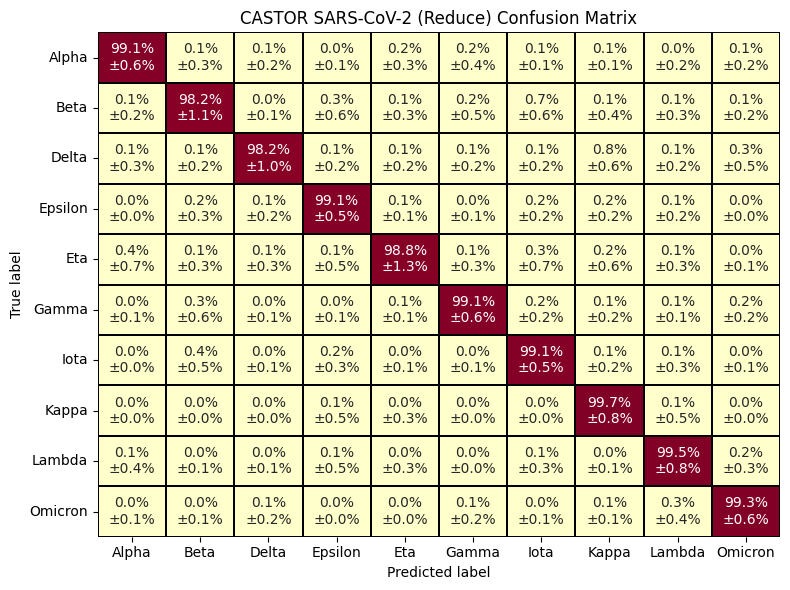

In [5]:
var = "sars"
# castor_results = f"{h}/castor-krfe-comparison/castor_results2/{var}/bench_{var}"
castor_results = f"{h}/castor-krfe-comparison/castor_results2/{var}"
kevolve_results = f"{h}/kevolve_results/{var}/bench_{var}"

create_confusion_matrix_from_csv(castor_results, "CASTOR SARS-CoV-2 (Reduce) Confusion Matrix", id_to_variant)

## Parse for our output

In [2]:
def parse_confusion_matrix(matrix_str):

    matrix_str = matrix_str.strip('[]')
    
    rows = matrix_str.split(';')
    
    matrix_data = []
    for row in rows:
        numbers = [int(x) for x in row.strip().split() if x.strip()]
        matrix_data.append(numbers)
    
    return np.array(matrix_data)

def analyze_confusion_matrices_from_csv(csv_file_path):

    df = pd.read_csv(csv_file_path, header=None)
    
    # A última coluna contém as matrizes de confusão
    matrix_column = df.iloc[:, -1]
    
    # Converte cada string de matriz em numpy array
    confusion_matrices = []
    for matrix_str in matrix_column:
        try:
            cm = parse_confusion_matrix(matrix_str)
            confusion_matrices.append(cm)
        except Exception as e:
            print(f"Erro ao processar matriz: {matrix_str[:50]}... - {e}")
            continue
    
    if not confusion_matrices:
        raise ValueError("Nenhuma matriz de confusão válida encontrada!")
    
    return np.array(confusion_matrices)

  

In [3]:
# labels = ["Omicron","Beta","Epsilon","Eta","Gamma","Lambda","Delta","Kappa","Iota","Alpha"]
# labels = ["B",'A','C','D','E','F']
# labels = ["type3","type1","type4","type2"]
labels = ["HIV1_F","HIV1_C","HIV1_D","HIV1_B","HIV1_G","HIV1_A"]


# results = analyze_confusion_matrices_from_csv("/home/salipe/Desktop/genomic-extractor/GREAC/exec3/benchmark_results_sars.csv")
# results = analyze_confusion_matrices_from_csv("/home/salipe/Desktop/GREAC/GREAC/output-6/benchmark_results_denv.csv")
# results = analyze_confusion_matrices_from_csv("/home/salipe/Desktop/GREAC/GREAC/output-9/benchmark_results_sars.csv")
# results = analyze_confusion_matrices_from_csv("/home/salipe/Desktop/genomic-extractor/GREAC/exec3/benchmark_results_hbv.csv")
results = analyze_confusion_matrices_from_csv("/home/salipe/Desktop/GREAC/GREAC/output-7/benchmark_results_hiv.csv")
# results = analyze_confusion_matrices_from_csv("/home/salipe/Desktop/GREAC/GREAC/output-7/benchmark_results_hbv.csv")
len(results)

Erro ao processar matriz: cm... - invalid literal for int() with base 10: 'cm'


10

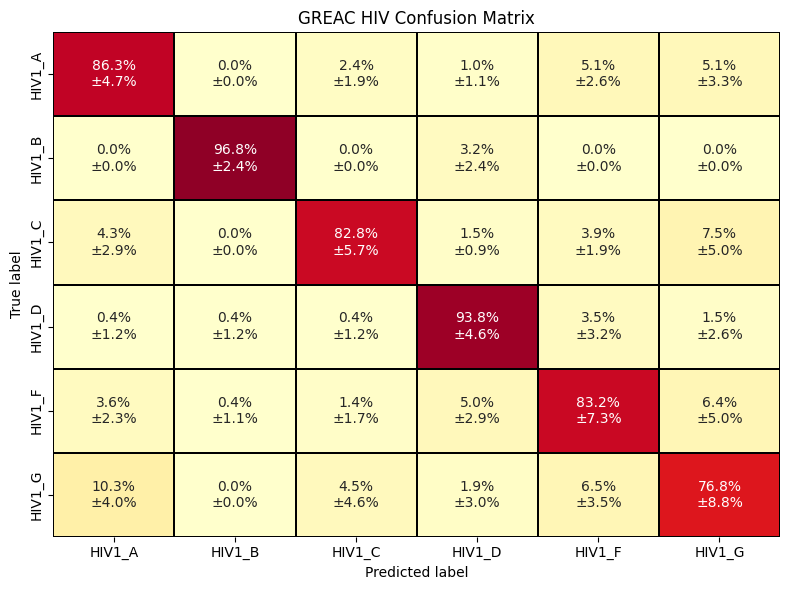

In [4]:
# ===== MATRIZ DE CONFUSÃO COM DESVIO PADRÃO =====
covlabels = ["Alpha", "Beta", "Delta", "Epsilon", "Eta", "Gamma", "Iota", "Kappa", "Lambda", "Omicron"]
hbvlabels = ["A", "B", "C", "D", "E", "F"]
denvlabels = ["type1","type2","type3","type4"]
hivlabels = ["HIV1_A","HIV1_B","HIV1_C","HIV1_D","HIV1_F","HIV1_G"]

changelabel = hivlabels

confusion_matrices = np.array(results)

# Calcula média e desvio padrão das matrizes de confusão
cm_mean = np.mean(confusion_matrices, axis=0)
cm_std = np.std(confusion_matrices, axis=0)

# Cria DataFrames para as matrizes
cm_mean_df = pd.DataFrame(cm_mean, index=labels, columns=labels)

cm_std_df = pd.DataFrame(cm_std, index=labels, columns=labels)

# Cria matriz combinada (média ± desvio padrão)
cm_combined = pd.DataFrame(index=labels, columns=labels)

for i, true_label in enumerate(labels):
    for j, pred_label in enumerate(labels):
        mean_val = cm_mean[i, j]
        std_val = cm_std[i, j]
        cm_combined.loc[true_label, pred_label] = f"{mean_val:.1f} ± {std_val:.1f}"

# ===== VISUALIZAÇÃO =====

# Normaliza a matriz de confusão por linha (divide cada linha pela soma da linha)
# Isso converte contagens absolutas em proporções/porcentagens por classe verdadeira
cm_normalized = cm_mean / cm_mean.sum(axis=1, keepdims=True)
cm_normalized_df = pd.DataFrame(cm_normalized, index=labels, columns=labels)
cm_normalized_df = cm_normalized_df.reindex(columns=changelabel)  # para colunas
cm_normalized_df = cm_normalized_df.reindex(index=changelabel)  # para linhas


# Calcula desvio padrão normalizado também
cm_matrices_normalized = np.array([cm / cm.sum(axis=1, keepdims=True) for cm in confusion_matrices])
cm_std_normalized = np.std(cm_matrices_normalized, axis=0)

# Reordena os dados normalizados e desvio padrão na ordem correta (covlabels)
idx_map = [labels.index(lbl) for lbl in changelabel]
cm_normalized_reordered = cm_normalized[idx_map, :][:, idx_map]
cm_std_normalized_reordered = cm_std_normalized[idx_map, :][:, idx_map]

# Cria as anotações com os dados reordenados
annotations = np.empty_like(cm_normalized_reordered, dtype=object)
for i in range(cm_normalized_reordered.shape[0]):
    for j in range(cm_normalized_reordered.shape[1]):
        mean_val = cm_normalized_reordered[i, j]
        std_val = cm_std_normalized_reordered[i, j]
        annotations[i, j] = f"{mean_val*100:.1f}%\n±{std_val*100:.1f}%"



# Criar figura única
fig, ax = plt.subplots(figsize=(8, 6))

# Heatmap com matriz normalizada (valores entre 0 e 1)
sns.heatmap(ax=ax,
            data=cm_normalized_df,
            annot=annotations,
            fmt="",
            cmap='YlOrRd',
            linecolor="black",
            linewidths=.1,
            cbar=False,
            vmin=0,
            vmax=1)

# ax.set_xticklabels(covlabels)
ax.set_title("GREAC HIV Confusion Matrix")
# X and Y Labels
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")

# Y ticks labels
# ax.yaxis.set_ticklabels(covlabels, rotation=0)

plt.tight_layout()
# plt.savefig("greac_sars_cm_4.pdf", dpi=300, format="pdf", bbox_inches="tight")
plt.show()
